**Done:**
 - ...


**Doing:**
 - 1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
 - 1 pt: explore advanced optimizers and regularization methods
 - 1 pt: optimize hyperparameters using grid/random search and cross-validation
 - 1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes

**Todo:**
- 1 pt: implement and test denoising (convolutional) autoencoder
- 1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)

- 2 pt: implement variational (convolutional) autoencoder or GAN


In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Set the random seed for reproducible results
torch.manual_seed(0)

Training device: cuda


# 1) Dataset

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

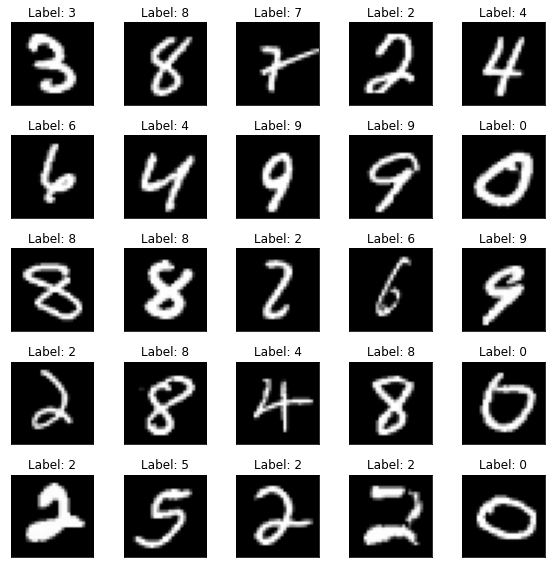

In [3]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## 1.1) Dataset Transform

In [4]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## 1.2) Dataloader

In [6]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 2) Model

## 2.1) Encoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second convolutional layer
            nn.Conv2d(conv1, conv2, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third convolutional layer
            nn.Conv2d(conv2, conv3, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)#dimension 0 is the sample, so we flatten from dimension 1

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * conv3, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## 2.2) Decoder

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, 3 * 3 * conv3),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3, conv2, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2, conv1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# 3) Train

## 3.1) Training Functions

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return loss.data

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
### Training cycle
def training_cycle(num_epochs,early_stopping,encoder,decoder,loss_fn,optim,train_dataloader,device,test_dataset):
    train_loss_log = []
    val_loss_log = []

    max_early=float("-inf")
    idx_early=-1

    for epoch in range(num_epochs):
        #print('\t EPOCH %d/%d' % (epoch + 1, num_epochs))

        ### Training (use the training function)
        train_loss=train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_log.append(train_loss)
        print('\t TRAIN - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))

        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)
        val_loss_log.append(val_loss)
        print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optim_params.pth')


        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss),3)<round(float(max_early),3):
            idx_early=epoch
            max_early=val_loss
            
        elif epoch-idx_early>=early_stopping:
            print("STOPPED BY EARLY STOPPYNG")
            break
    
    return (train_loss_log,val_loss_log)
    
    

## 3.2) Grid Search

In [ ]:
"""
Hyperparams:
encoded_space_dim = [2, 4, 128]
num_epochs=50
early_stopping=5
Conv1=[8,16,32,64]
Conv2=[8,16,32,64]
Conv3=[8,16,32,64]
FC=[32,64,128]
LR=[1e-2,1e-3,1e-4]
L2=[1e-3,1e-4,1e-5]
drop=[0,0.25,0.5,0.75]

"""

space_dim = [2]
num_epochs=50
early_stopping=8
Conv1=[8]
Conv2=[16]
Conv3=[32]
FC=[64]
LR=[1e-3]
L2=[1e-5]
drop=0


hyperparams = [space_dim,Conv1,Conv2,Conv3,FC,LR,L2]  

iterations=[]
import itertools
for hyper in itertools.product(*hyperparams):
    iterations.append(hyper)
print("Total Combinations:",len(iterations))


best_hyper=None
best_loss=None
for i,hyper in enumerate(iterations):
    print("\n\nIteration:",i,hyper)
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=hyper
    
    ### Initialize the two networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
    decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

    # Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)
    
    
    #TRAINING CYCLE
    train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device,
                                           test_dataset)
    train_loss=train_loss_log[-1]
    val_loss=val_loss_log[-1]
    print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))
    
    if not best_loss or val_loss<best_loss:
        best_loss=val_loss
        best_hyper=hyper

        
print("\n\nBest Model:",best_hyper)

In [ ]:
# Retrain the best model
if best_hyper:
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=best_hyper
    print("Training:",best_hyper)


### Initialize the two networks
encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

# Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
    
    
train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device,
                                           test_dataset)

## 3.3) Plot Losses

In [ ]:
# Plot losses of the best model
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## 3.4) Metric Summary

In [ ]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))

# 4) Latent Space Visualization and Sample Generation

## 4.1) Latent Space Visualization with T-SNE

In [ ]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
labels=[]
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    #encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    #encoded_sample['label'] = label
    #encoded_samples.append(encoded_sample)
    encoded_samples.append(encoded_img)
    labels.append(str(label))

In [ ]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(encoded_samples)

In [ ]:
#Plot
#plt.scatter(X_tsne[:,0],X_tsne[:,1],c=labelsint)
#plt.show()

In [ ]:
import plotly.express as px
px.scatter(x=X_tsne[:,0], y=X_tsne[:,1], color=labels, opacity=0.7)

## 4.2) Sample Generation

In [ ]:
if encoded_space_dim == 10:
    # Generate a custom sample
    custom_encoded_sample = [-12,-28,-30,-5,-31,6,7,8,9,10]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

In [ ]:
#........................................

---
---
---
# 5) Denoising Autoencoder

In [21]:
def gaussian_noise(image, noise_factor):
    
    # torch.randn returns random values from a normal with mean 0 and variance 1 -> Gaussian noise!
    noisy_img = image + noise_factor * torch.randn(image.shape)
    #clip the image
    noisy_img = np.clip(noisy_img, 0., 1.)
    
    return noisy_img

## 5.1) Plot some Corrupted images and Recostruction with the normal ConvAE

In [ ]:
corr_imgs, rec_imgs  = [], []

for i in range(10):
    imgc = test_dataset[0][0].unsqueeze(0)
    corr_imgs.append(gaussian_noise(imgc, 0.1*i))

for i in range(len(corr_imgs)):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Move tensor to the proper device
        image_batch = corr_imgs[i].to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Append the network output and the original image to the lists
        rec_imgs.append(decoded_data.cpu())

        
# plot the corrupted input image and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for corr_imgs, row in zip([corr_imgs, rec_imgs], axes):
    for img, ax in zip(corr_imgs, row):
        
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## 5.2) Train the Denoise AutoEncoder

In [22]:
class noise(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        noise_factor=0.1*3
        noisy_img = image + noise_factor * torch.randn(image.shape)
        #clip the image
        noisy_img = np.clip(noisy_img, 0., 1.)

        return (image,noisy_img)

In [23]:
# IN TRAIN TRASFORM 
train_transform_noise = transforms.Compose([
    transforms.ToTensor(),
    noise(),
])
test_transform_noise = transforms.Compose([
    transforms.ToTensor(),
    noise(),
])

In [24]:
train_dataset_noise = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset_noise  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

# Set the train transform
train_dataset_noise.transform = train_transform_noise
# Set the test transform
test_dataset_noise.transform = test_transform_noise

In [25]:
### Define train dataloader
train_dataloader_noise = DataLoader(train_dataset_noise, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader_noise = DataLoader(test_dataset_noise, batch_size=256, shuffle=False)

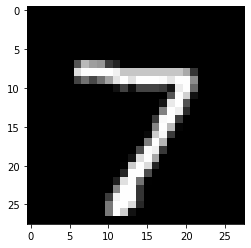

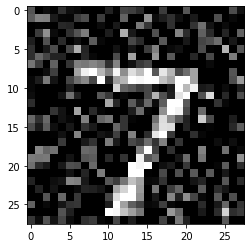

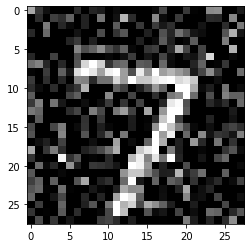

In [26]:
#Check if the transformation works
for image in test_dataloader_noise:
    
    plt.imshow(image[0][0][0][0],cmap='gray')
    plt.show()
    plt.close()
    plt.imshow(image[0][1][0][0],cmap='gray')
    plt.show()
    plt.close()
    
    break

img=test_dataset_noise[0][0][1].unsqueeze(0).to(device)

plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
plt.show()

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,noise=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    
    
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image= image_batch[0].to(device)
        
        noisy=image
            
        if noise: 
            noisy=image_batch[1].to(device)

        
        
        # Encode data
        encoded_data = encoder(noisy)
        
        # Decode data
        decoded_data = decoder(encoded_data)
        
        # Evaluate loss
        loss = loss_fn(decoded_data, image)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        
    return loss.data

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn,noise=False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        
        
        
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image= image_batch[0].to(device)
        
            noisy=image
            
            if noise: 
                noisy=image_batch[1].to(device)
                
            # Encode data
            encoded_data = encoder(noisy)
            
            # Decode data
            decoded_data = decoder(encoded_data)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
### Training cycle
def training_cycle(num_epochs,early_stopping,encoder,decoder,loss_fn,optim,train_dataloader,device,test_dataset,test_dataloader):
    train_loss_log = []
    val_loss_log = []

    max_early=float("-inf")
    idx_early=-1

    for epoch in range(num_epochs):
        #print('\t EPOCH %d/%d' % (epoch + 1, num_epochs))

        ### Training (use the training function)
        train_loss=train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim,
            noise=True)
        train_loss_log.append(train_loss)
        print('\t TRAIN - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))

        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn,
            noise=True)
        val_loss_log.append(val_loss)
        print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset_noise[0][0][1].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optim_params.pth')


        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss),3)<round(float(max_early),3):
            idx_early=epoch
            max_early=val_loss
            
        elif epoch-idx_early>=early_stopping:
            print("STOPPED BY EARLY STOPPYNG")
            break
    
    return (train_loss_log,val_loss_log)
    
    

In [ ]:
# Retrain the best model
"""if best_hyper:
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=best_hyper
    print("Training:",best_hyper)"""

encoded_space_dim = 10
num_epochs=50
early_stopping=5
conv1=8
conv2=16
conv3=32
fc=64
lr=1e-3
l2=1e-5
drop=0

### Initialize the two networks
encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

# Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
    
    
train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader_noise,
                                           device,
                                           test_dataset_noise,
                                           test_dataloader_noise)

In [ ]:
# Plot losses of the best model
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))

## 5.3) Plot some Corrupted images and Recostruction with the Denoise ConvAE

In [ ]:
corr_imgs, rec_imgs  = [], []

for i in range(10):
    imgc = test_dataset[0][0].unsqueeze(0)
    corr_imgs.append(gaussian_noise(imgc, 0.1*i))

for i in range(len(corr_imgs)):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Move tensor to the proper device
        image_batch = corr_imgs[i].to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Append the network output and the original image to the lists
        rec_imgs.append(decoded_data.cpu())

        
# plot the corrupted input image and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for corr_imgs, row in zip([corr_imgs, rec_imgs], axes):
    for img, ax in zip(corr_imgs, row):
        
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

---
---
---
---
# 6) Supervised Classification

In [ ]:
outputLayer = nn.Linear(encoded_space_dim, 10)
outputLayer = outputLayer.to(device)

In [ ]:


train_loss_log = []
val_loss_log = []

max_early=float("-inf")
idx_early=-1

for epoch in range(num_epochs):
    #print('\t EPOCH %d/%d' % (epoch + 1, num_epochs))

    ### Training (use the training function)
    train_loss=train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    
    
    
    
    
    
    train_loss_log.append(train_loss)
    print('\t TRAIN - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))

    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    val_loss_log.append(val_loss)
    print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset_noise[0][0][1].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')
    torch.save(optim.state_dict(), 'optim_params.pth')


    #Early stopping:
    if idx_early==-1:
        idx_early=epoch
        max_early=val_loss
    elif round(float(val_loss),3)<round(float(max_early),3):
        idx_early=epoch
        max_early=val_loss

    elif epoch-idx_early>=early_stopping:
        print("STOPPED BY EARLY STOPPYNG")
        break

---
---
---
---
# 7) Variational Autoencoder

In [44]:
import torch.nn.functional as F
features = 16
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
        
        self.flatten = nn.Flatten(start_dim=1)
        
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = self.flatten(x)
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var


In [45]:
### Training function
def train_epoch(VaAE, device, dataloader, loss_fn, optimizer,noise=False):
    # Set train mode for both the encoder and the decoder
    VaAE.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    
    
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image= image_batch[0].to(device)
        
        noisy=image
            
        if noise: 
            noisy=image_batch[1].to(device)

        #Forward
        out=VaAE(noisy)
        
        # Evaluate loss
        loss = loss_fn(out, image)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        
    return loss.data

In [46]:
### Testing function
def test_epoch(VaAE, device, dataloader, loss_fn,noise=False):
    # Set evaluation mode for encoder and decoder
    VaAE.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        
        
        
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image= image_batch[0].to(device)
        
            noisy=image
            
            if noise: 
                noisy=image_batch[1].to(device)
                
            #Predict
            out=VaAE(noisy)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [47]:
### Training cycle
def training_cycle(num_epochs,early_stopping,VaAE,loss_fn,optim,train_dataloader,device,test_dataset,test_dataloader):
    train_loss_log = []
    val_loss_log = []

    max_early=float("-inf")
    idx_early=-1

    for epoch in range(num_epochs):
        #print('\t EPOCH %d/%d' % (epoch + 1, num_epochs))

        ### Training (use the training function)
        train_loss=train_epoch(
            VaAE=VaAE, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim,
            noise=True)
        train_loss_log.append(train_loss)
        print('\t TRAIN - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))

        ### Validation  (use the testing function)
        val_loss = test_epoch(
            VaAE=VaAE, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn,
            noise=True)
        val_loss_log.append(val_loss)
        print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset_noise[0][0][1].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = VaAE(img)
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        # Save figures
        os.makedirs('Var_autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        fig.savefig('Var_autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optim_params.pth')


        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss),3)<round(float(max_early),3):
            idx_early=epoch
            max_early=val_loss
            
        elif epoch-idx_early>=early_stopping:
            print("STOPPED BY EARLY STOPPYNG")
            break
    
    return (train_loss_log,val_loss_log)
    
    

In [48]:
# Retrain the best model
"""if best_hyper:
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=best_hyper
    print("Training:",best_hyper)"""

encoded_space_dim = 10
num_epochs=50
early_stopping=5
conv1=8
conv2=16
conv3=32
fc=64
lr=1e-3
l2=1e-5
drop=0

### Initialize the two networks
VaAE = LinearVAE()

# Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': VaAE.parameters()},
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

# Move both the encoder and the decoder to the selected device
VaAE.to(device)
    
    
train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           VaAE,
                                           loss_fn,
                                           optim,
                                           train_dataloader_noise,
                                           device,
                                           test_dataset_noise,
                                           test_dataloader_noise)

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
# Plot losses of the best model
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [33]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))

NameError: name 'train_loss_log' is not defined